In [1]:
# algunas librerias por las dudas :P 
import numpy as np
import pandas as pd 
import os

from numpy import array

import h5py
import matplotlib.pyplot as mplt

# instalar transformers y levanto la info de beto

In [2]:
# Fist install the library and download the models from github

!pip install transformers
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

     |████████████████████████████████| 778kB 5.7MB/s 
     |████████████████████████████████| 3.0MB 30.5MB/s 
     |████████████████████████████████| 1.1MB 43.0MB/s 
     |████████████████████████████████| 890kB 51.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=4044dcd614096709cdefd5624a64a9624d178f2ce7d8d31e1d91d3a56e3dbe1d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
--2020-08-06 21:41:38--  https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz
Resolving users.dcc.uchile.cl (users.dcc.uchile.cl)... 192.80.24.4, 200.9.99.211
Connecting to users.dcc.uchile.cl (users.dcc.uchile.cl)|192.80.24.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409871727 (391M) [application/x-gzip]
Saving to: ‘pytorch_weights.tar.gz’

pytorch_weights.tar 100%[===================>] 390.88M  2.62MB/s    in 72s     

20

In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

from transformers import BertForMaskedLM

#esto lo necesito para poder pasar el modelo a tensorflow
from transformers import DistilBertModel as model_class

import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap

In [5]:
# TOKENIZACIÓN
PRE_TRAINED_MODEL_NAME="pytorch/"
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


In [6]:
# Inicialización
BATCH_SIZE = 8
NCLASSES = 3
RANDOM_SEED=42
MAX_LEN = 200
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# Ejemplo tokenización
sample_txt = 'yo quiero hacerlo'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print('Frase: ', sample_txt)
print('Tokens: ', tokens)
print('Tokens numéricos: ', token_ids)

Frase:  yo quiero hacerlo
Tokens:  ['yo', 'quiero', 'hacerlo']
Tokens numéricos:  [1467, 1937, 2791]


In [8]:
# Codificación para introducir a BERT
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 140,
    truncation = True,
    add_special_tokens = True,
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt'
)

In [9]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [10]:
#la estructura de la mascara necesita el [CLS] y [SEP]

print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))
print(encoding['input_ids'][0])
print(encoding['attention_mask'][0])

['[CLS]', 'yo', 'quiero', 'hacerlo', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 

## **datos**

In [11]:
df_claro = pd.DataFrame(pd.read_excel("/content/claro_prev.xlsx"))
df_movi = pd.DataFrame(pd.read_excel("/content/movistar_prev.xlsx"))
df_perso = pd.DataFrame(pd.read_excel("/content/personal_prev.xlsx"))

df_claro['company'] = 'claro'

df_movi['company'] = 'movistar'

df_perso['company'] = 'personal'



In [12]:
#eliminamos todos los tweets de claro asociados a publicidad de eventos de gaming
df_claro=df_claro[df_claro.author_name != '9zTeam']
df_claro=df_claro[~df_claro.text.str.contains('9zteam',case=True)]


In [13]:
df_todos=pd.concat([df_claro, df_movi,df_perso])

df_todos.shape

(3332, 7)

In [14]:
df_todos.head(2)

,label,text,author_name,created_at,id,text_clean,company
0,1,"Hola @ClaroArgentina ,chau @TuentiAR",pasameuntrago74,2020-07-18 09:40:09,1284422700346286080,hola @claroargentina chau @tuentiar,claro
1,1,Hola @PersonalAr buen día.\nConsulta: pueden m...,DanielPaganetti,2020-07-18 12:12:45,1284461102001197056,hola @personalar buen dia consulta pueden mejo...,claro


In [15]:
aux=pd.pivot_table(df_todos,aggfunc='count',columns='label',index='company' ,values='id')
print(aux)
# 0 negativo 1 positivo 2 neutro

label       0    1    2
company                
claro     345  119  887
movistar  683   40  352
personal  558  104  244


In [16]:
aux['nps']=(aux[1]-aux[0])/(aux[1]+aux[0]+aux[2])
print(aux)

label       0    1    2       nps
company                          
claro     345  119  887 -0.167283
movistar  683   40  352 -0.598140
personal  558  104  244 -0.501104


In [17]:
aux.to_csv('nps.csv', index=False)

los pasos previos para poder usar el modelo con pytorch

In [18]:
# CREACIÓN DATASET en el formato que necesita pytorch/bert

class MovilDataset(Dataset):

  def __init__(self,text,labels,tokenizer,max_len):
    self.text = text
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
      return len(self.text)
    
  def __getitem__(self, item):
    text = str(self.text[item])
    label = self.labels[item]
    encoding = tokenizer.encode_plus(
        text,
        max_length = self.max_len,
        truncation = True,
        add_special_tokens = True,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
        )
    

    return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
      }

In [19]:

# arma el dData loader:

def data_loader(df, tokenizer, max_len, batch_size):
  dataset = MovilDataset(
      text = df.text.to_numpy(),
      labels = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = MAX_LEN
  )

  return DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = 4)

acá separo train y test

In [20]:
##  armo los splits para poder empezar a modelar ###
df_train, df_test = train_test_split(df_todos, test_size = 0.2, random_state=RANDOM_SEED)

train_data_loader = data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
## armo y para despues podes validar ###
y_train =df_train['label']
y_test =df_test['label']

#y_train = pd.get_dummies(y_train, columns=['label'])
#y_test = pd.get_dummies(y_test, columns=['label'])
print(y_train.shape)
print(y_test.shape)

(2665,)
(667,)


In [22]:
# acá arma el modelo
class BERTSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(BERTSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.25)
    self.linear = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, cls_output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    )
    drop_output = self.drop(cls_output)
    output = self.linear(drop_output)
    return output

In [23]:
model = BERTSentimentClassifier(NCLASSES)
model = model.to(device)

In [24]:
# ENTRENAMIENTO
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [25]:
# Iteración entrenamiento
def train_model(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  for batch in data_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    outputs = model(input_ids = input_ids, attention_mask = attention_mask)
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double()/n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for batch in data_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask = attention_mask)
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, labels)
      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
  return correct_predictions.double()/n_examples, np.mean(losses)

In [26]:
# la corrida

for epoch in range(EPOCHS):
  print('Epoch {} de {}'.format(epoch+1, EPOCHS))
  print('------------------')
  train_acc, train_loss = train_model(
      model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train)
  )
  test_acc, test_loss = eval_model(
      model, test_data_loader, loss_fn, device, len(df_test)
  )
  print('Entrenamiento: Loss: {}, accuracy: {}'.format(train_loss, train_acc))
  print('Validación: Loss: {}, accuracy: {}'.format(test_loss, test_acc))
  print('')

Epoch 1 de 5
------------------
Entrenamiento: Loss: 0.696183391807679, accuracy: 0.7227016885553471
Validación: Loss: 0.5489751647803045, accuracy: 0.793103448275862

Epoch 2 de 5
------------------
Entrenamiento: Loss: 0.45934105586416707, accuracy: 0.8311444652908068
Validación: Loss: 0.6670872171054638, accuracy: 0.7946026986506747

Epoch 3 de 5
------------------
Entrenamiento: Loss: 0.313967484306031, accuracy: 0.9061913696060038
Validación: Loss: 0.8785947056742207, accuracy: 0.7976011994002998

Epoch 4 de 5
------------------
Entrenamiento: Loss: 0.208247974295724, accuracy: 0.9403377110694184
Validación: Loss: 1.0021920317418076, accuracy: 0.8020989505247376

Epoch 5 de 5
------------------
Entrenamiento: Loss: 0.15325069500336946, accuracy: 0.9613508442776736
Validación: Loss: 1.0540963227990905, accuracy: 0.8110944527736131



In [27]:
def classifySentiment(review_text):
  encoding_review = tokenizer.encode_plus(
      review_text,
      max_length = MAX_LEN,
      truncation = True,
      add_special_tokens = True,
      return_token_type_ids = False,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
      )
  
  input_ids = encoding_review['input_ids'].to(device)
  attention_mask = encoding_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  return [prediction]
  #print("\n".join(wrap(review_text)),prediction)


In [28]:
#exportar los pesos del modelo a onnx 
onnx_path =  "/content/beto.onnx"

torch_out =torch.onnx.export(model,(encoding['input_ids'].to(device),encoding['attention_mask'].to(device)),onnx_path, export_params=True)


In [ ]:
!pip install onnx

     |████████████████████████████████| 7.4MB 4.6MB/s 


In [ ]:
!pip install onnx_tf

In [ ]:
import onnx
#import onnx_tf
#from onnx_tf.backend import prepare



In [ ]:

onnx_model = onnx.load(onnx_path)  # load onnx model
output = prepare(onnx_model).run(input)  # run the loaded model

In [ ]:
onnx-tf convert -t beto.onnx -o beto.pb

In [36]:
tt = " Hola @PersonalAr  no solo es chocante que sin previo aviso aumenten sus tarifas, Sino que es abusivo hoy me doy con que el abono de mi hijo paso de $450 a $900 Cuando el plan que adquirimos hace 4 mes atras era por 12meses,Me quieren explicar??"

a=classifySentiment(tt)[0].item()
print(a)

0


In [39]:
t2 = "@PersonalAr  hola hay alguien ???"

classifySentiment(t2)[0].item()

2

In [31]:
x_test=pd.DataFrame(data=df_test['text'])
x_test.head()


,text
459,Una vez me llego 'por error' un mensaje al buz...
248,@PersonalAr recién entro a la empresa y ya me ...
1455,"Hola, @ClaroArgentina. Porqué la agencia ofici..."
606,"@MovistarArg no puedo activar la app, pueden a..."
797,Arregla el internet la concha de tu madre @Mov...


In [32]:
x_test['y_hat'] =x_test.text.apply(lambda x : classifySentiment(x)[0].item())

In [33]:
x_test.head(5)

,text,y_hat
459,Una vez me llego 'por error' un mensaje al buz...,2
248,@PersonalAr recién entro a la empresa y ya me ...,0
1455,"Hola, @ClaroArgentina. Porqué la agencia ofici...",2
606,"@MovistarArg no puedo activar la app, pueden a...",2
797,Arregla el internet la concha de tu madre @Mov...,0


In [ ]:
pred_label=x_test['y_hat']
#print(pred_label.shape)
#print(y_test)
print(pred_label)

459     2
248     0
1455    0
606     2
797     0
       ..
151     0
337     0
643     0
117     0
605     0
Name: y_hat, Length: 667, dtype: int64


In [ ]:
x_test.to_csv('predictions_dropout.csv', index=False)
y_test.to_csv('real.csv', index=False)


In [ ]:
df_test.to_excel('base_test.xlsx', index=False,)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
color = sns.color_palette()
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


              precision    recall  f1-score   support

    negativo       0.83      0.84      0.84       322
    positivo       0.34      0.32      0.33        50
      neutro       0.81      0.81      0.81       295

    accuracy                           0.79       667
   macro avg       0.66      0.66      0.66       667
weighted avg       0.78      0.79      0.79       667



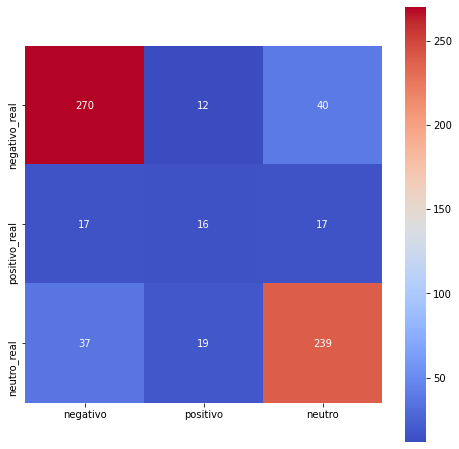

In [ ]:

target_names_real = ['negativo_real', 'positivo_real', 'neutro_real']
target_names = ['negativo', 'positivo', 'neutro']
mplt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(y_test, pred_label), fmt='g', annot=True, cmap='coolwarm', square=True,xticklabels=target_names, yticklabels=target_names_real)

print(classification_report(y_test, pred_label, target_names=target_names))